# Regularized Back Propagation Implementation

This notebook contains a full implementation of the back propagation algorithm with regularization. In a previous notebook, the back propagation algorithm (without regularization) was implemented. In this notebook, we add the regularization terms.

## Learning Objective

In this notebook, we will learn a noisy sine wave. It will be a function of a sine wave with some random gaussian noise added to the function. Using regularization to learn the sine wave will help avoid overfitting to the random noise.

The input to the network will be x/y coordinates on a graph, and the output will be a classification, 0 or 1, indicating if the coordinates are within a sine wave.

## Discussion

When tweaking the learning for weight decay / regularization, the major change happens to the loss / criterion function in our network. So we will add a regularization term to our binary cross entropy loss function:

$$L(\hat{Y}, Y) = (\sum_k Y_k \log (\hat{Y}_k) + (1 - Y_k) \log (1 - \hat{Y}_k)) + \frac {\lambda} {2m} \sum_l \left\Vert W^l \right\Vert^2 $$

The first sum contains the standard binary cross entropy loss while the second sum contains the weight penalty. We enumerate through the layers of the network and take sum of the square of all the weights. The penalty is controlled by a parameter $\lambda$ that dictates how much we want to punish the weights. We also normalize this by the total number of samples, $m$, so our regularization parameter is not sensitive to batch size.

*Note that we are not introducing a regularization penalty to bias.*

We will make a small tweak to the standard back propagation algorithm to get regularization working. We will modify the gradients with respect to weights to include an additions term: $\frac {\lambda} {m} W^l$.

Adding this term to the gradients of the weights is equivalent to backpropagating the regularized loss function.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

from time import time

In [2]:
num_points = 3000

amplitude = 2
period = 3.14159 / 2
range_min = -2
range_max = 2

noise_std = 0.2

train_percent = 0.6
valid_percent = 0.2
test_percent = 0.2

## Generating Our Data

In [3]:
def sin_wave(X):
    return amplitude * np.sin(X * period)


In [4]:
# We will generate half our points on the wave and half off the wave.

Xp = np.random.rand(math.floor(num_points / 2)) * (range_max - range_min) + range_min
Yp = sin_wave(Xp)

# Note that some of our negative samples may lie on the sin wave, and that's okay.
Y_mask = (np.random.rand(math.ceil(num_points / 2)) > 0.5).astype(float) * 2 - 1
Xn = np.random.rand(math.ceil(num_points / 2)) * (range_max - range_min) + range_min
Yn = np.random.rand(math.ceil(num_points / 2)) * (range_max - range_min) + range_min
      

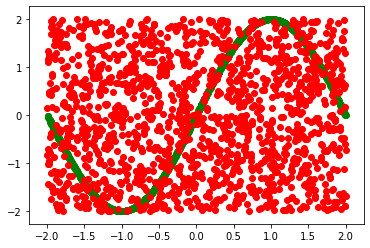

In [5]:
plt.scatter(Xp, Yp, c='g')
plt.scatter(Xn, Yn, c='r')

In [6]:
# Adding gaussian noise to our wave.
noise = np.random.randn(len(Xp)) * noise_std

Yp = Yp + noise

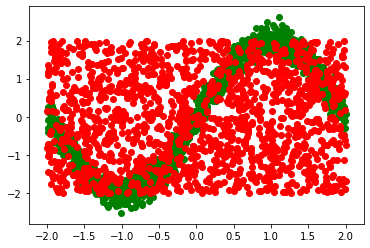

In [7]:
plt.scatter(Xp, Yp, c='g')
plt.scatter(Xn, Yn, c='r')

In [8]:
# Changing the data and labels to the proper shape for the classifier.

data = np.zeros((2, num_points))

data[0, :len(Xp)] = Xp
data[1, :len(Yp)] = Yp

data[0, -len(Xn):] = Xn
data[1, -len(Yn):] = Yn

labels = np.zeros(num_points)
labels[:len(Xp)] = 1

# Shuffling
shuffle_mask = np.random.permutation(num_points)
data = data[:, shuffle_mask]
labels = labels[shuffle_mask]

(len(Xn), len(Yn), len(Xp), len(Yp))

(1500, 1500, 1500, 1500)

### Standardizing the Data

In [9]:
def create_standardization_funcs(data):
    m = data.shape[1] # number of samples
    
    mean = (np.sum(data, axis=1) / m).reshape(-1, 1)
    variance = np.sum(data * data, axis=1).reshape(-1, 1) / m
    std = np.sqrt(variance)

    def standardize(data):
        return (data - mean) / std
    
    def unstandardize(data):
        return data * std + mean
    
    return standardize, unstandardize


In [10]:
standardize, unstandardize = create_standardization_funcs(data)

### Splitting into Train / Validation / Test sets

In [11]:
# Note: Data is shuffled.

train_count = math.floor(num_points * train_percent)
valid_count = math.floor(num_points * valid_percent)
test_count = num_points - train_count - valid_count

data_train = data[:, :train_count]
labels_train = labels[:train_count]

data_valid = data[:, train_count:(train_count + valid_count)]
labels_valid = labels[train_count:(train_count + valid_count)]

data_test = data[:, -test_count:]
labels_test = labels[-test_count:]

## Creating Model

This code is, for the most part, copied from a previous notebook. The loss functions and backward propagations are tweaked to have regularization.

### Activation Functions

In [12]:
def relu(X):
    mask = X >= 0
    return X * mask


In [13]:
def relu_deriv(X):
    return (X >= 0).astype(float)


In [14]:
def sigmoid(X):
    return 1. / (1 + np.exp(-X))


In [15]:
def sigmoid_deriv(X):
    sig = sigmoid(X)
    return sig * (1 - sig)


### Loss Functions

In [16]:
def binary_cross_entropy_loss(output, expected):
    # Offset the output if there are any values exactly equal to
    # zero or one to avoid log(0).
    zero_correct = (output == 0).astype(float) * 1e-10 
    one_correct = (output == 1).astype(float) * (-1e-10)
    output = output + zero_correct + one_correct

    return np.sum((expected * -np.log(output)) + (1 - expected) * -np.log(1 - output))


In [17]:
def binary_cross_entropy_loss_grad(output, expected):    
    # Want to avoid divide by 0.
    epsilon = 1e-10
    zero_correct = (output == 0.0).astype(float) * epsilon
    one_correct = (output == 1.0).astype(float) * -epsilon
    output = output + zero_correct + one_correct
    
    return (-(expected / output) + (1 - expected) / (1 - output))


In [18]:
def binary_cross_entropy_loss_reg(model, lambd, sample_size, output, expected):
    error_penalty = binary_cross_entropy_loss(output, expected)
    
    weight_penalty = 0
    for weight, _ in model['layers']:
        weight_penalty += np.sum(weight * weight)
    weight_penalty *= (lambd / sample_size)
    
    return error_penalty + weight_penalty
    

### Random Initialization

In [19]:
# Note: When initializing the layers, we will assume that the output
# layer is always a single output through a sigmoid activation.
def xavier_initialization(input_size, layer_sizes):
    layers = []
    
    prev_layer_size = input_size

    for size in layer_sizes:
        normalize = 1. / math.sqrt(prev_layer_size)
        weights = np.random.randn(size, prev_layer_size) * normalize
        biases = np.random.randn(size, 1) * normalize
        layers.append((weights, biases))

        prev_layer_size = size
        
    # Add a final output layer for sigmoid activation.
    weights = np.random.randn(1, prev_layer_size)
    biases = np.random.randn(1, 1)
    layers.append((weights, biases))
    
    return layers


### Model Functions

In [20]:
def forward(model, X_raw):
    # Standardize data before passing it through the network.
    X = model['standardize'](X_raw)
    Y = X

    linear_outputs = []
    outputs = []

    for weights, biases in model['layers'][0:-1]:
        Y = np.dot(weights, Y) + biases
        linear_outputs.append(Y)

        Y = relu(Y)
        outputs.append(Y)
        

    # Note: Last layer is processed by sigmoid activation.
    weights, biases = model['layers'][-1]

    Y = np.dot(weights, Y) + biases
    linear_outputs.append(Y)

    Y = sigmoid(Y)
    outputs.append(Y)

    # Save the results of the forward pass so we can do a backward
    # pass on them later.
    if 'no_grad' not in model or not model['no_grad']:
        model['linear_outputs'] = linear_outputs
        model['input'] = X
        model['outputs'] = outputs
        model['result'] = Y

    return Y
 

In [21]:
def predict(model, X):
    Y_hat = forward(model, X)
    return (Y_hat >= 0.5).astype(float).reshape(-1)
    

In [22]:
def backward(model, expected, lambd, batch_size):
    # Note: We are assuming the model has already gone through a
    # forward pass.

    layers = model['layers']
    linear_outputs = model['linear_outputs']
    outputs = model['outputs']
    X = model['input']
    result = model['result']

    L = len(layers)
    m = result.shape[1] # Number of samples.

    # Keep track of error derivatives and gradients. These lists represent
    # the errors and gradients in reverse order with respect to the layers
    # in the network. The order is reversed after all the computations have
    # been completed.
    errors = []
    grads = []

    # Note: We can have multiple samples in the outputs, so we
    # will end up with a gradient per sample.
    loss_grad = binary_cross_entropy_loss_grad(result, expected)

    weights = layers[-1][0]
    linear_output = linear_outputs[-1]
    output_prev_layer = X if len(outputs) <= 1 else outputs[-2]
    error_last_layer = loss_grad * sigmoid_deriv(linear_output)

    bias_grad = np.sum(error_last_layer, axis=1).reshape(-1, 1)
    weights_grad = np.dot(error_last_layer, output_prev_layer.T) # outer product
    weights_grad += (lambd / batch_size) * weights # regularization term
    grad_last_layer = (weights_grad, bias_grad)

    errors.append(error_last_layer)
    grads.append((weights_grad, bias_grad))

    # Enumerate layers in reverse order to compute errors
    # and gradients.
    for i in range(L - 2, -1, -1):
        weights = layers[i][0]
        linear_output = linear_outputs[i]
        output_prev_layer = X if i == 0 else outputs[i-1]
        error_next_layer = errors[-1]
        weights_next_layer, bias_next_layer = layers[i+1]

        error = np.dot(weights_next_layer.T, error_next_layer) * relu_deriv(linear_output)
        bias_grad = np.sum(error, axis=1).reshape(-1, 1)
        weights_grad = np.dot(error, output_prev_layer.T) # outer product
        weights_grad += (lambd / batch_size) * weights # regularization term
        
        errors.append(error)
        grads.append((weights_grad, bias_grad))
        
    # Reverse the order of errors and gradients so they go from
    # first layer to last.
    errors.reverse()
    grads.reverse()
    
    if 'no_grad' not in model or not model['no_grad']:
        model['errors'] = errors
        model['grads'] = grads
    
    return grads, errors


In [23]:
def loss(model, X, Y):
    output = forward(model, X)
    return binary_cross_entropy_loss(output, Y)


In [24]:
def grad_off(model):
    model['no_grad'] = True


In [25]:
def grad_on(model):
    model['no_grad'] = False


### Gradient Update

In [26]:
def reset_Adam(model):
    # We keep track of exponential moving averages of our
    # Adam optimization algorithm, cached in the model.
    # If we are starting to train from scratch, we need
    # to know to set these averages to 0.
    mt = []
    vt = []

    for (i, layers) in enumerate(model['layers']):
        weight, bias = layers
        mt.append((np.zeros_like(weight), np.zeros_like(bias)))
        vt.append((np.zeros_like(weight), np.zeros_like(bias)))
        
    model['mt'] = mt
    model['vt'] = vt
    model['t'] = 0


In [27]:
def step_Adam(model, lr, batch_size, beta_1=0.9, beta_2=0.999, epsilon=1e-30):
    # Note: We are assuming the model has already gone through
    # back propagation and all the gradients have been calculated.
    
    t = model['t'] + 1

    one_minus_beta_1 = 1 - beta_1
    one_minus_beta_2 = 1 - beta_2

    one_minus_beta_1t = 1 - math.pow(beta_1, t)
    one_minus_beta_2t = 1 - math.pow(beta_2, t)

    for (i, layer) in enumerate(model['layers']):
        weight, bias = layer
        grad_weight, grad_bias = model['grads'][i]

        mt_minus_1_weight, mt_minus_1_bias = model['mt'][i]
        vt_minus_1_weight, vt_minus_1_bias = model['vt'][i]
        
        # Calculating exponentially moving averages.
        mt_weight = beta_1 * mt_minus_1_weight + one_minus_beta_1 * grad_weight
        mt_bias = beta_1 * mt_minus_1_bias + one_minus_beta_1 * grad_bias
        
        vt_weight = beta_2 * vt_minus_1_weight + one_minus_beta_2 * grad_weight * grad_weight
        vt_bias = beta_2 * vt_minus_1_bias + one_minus_beta_2 * grad_bias * grad_bias

        # Bias correction of our moving averages.
        mt_hat_weight = mt_weight / one_minus_beta_1t
        mt_hat_bias = mt_bias / one_minus_beta_1t
        vt_hat_weight = vt_weight / one_minus_beta_2t
        vt_hat_bias = vt_bias / one_minus_beta_2t

        # Calculate change in weights.
        deltat_weight = mt_hat_weight / (np.sqrt(vt_hat_weight) + epsilon)
        deltat_bias = mt_hat_bias / (np.sqrt(vt_hat_bias) + epsilon)
        
        # Update weights.
        weight = weight - (lr / batch_size * deltat_weight)
        bias = bias - (lr / batch_size * deltat_bias)

        # Write to model.
        model['layers'][i] = (weight, bias)
        model['mt'][i] = (mt_weight, mt_bias)
        model['vt'][i] = (vt_weight, vt_bias)

    
    model['t'] = t


### Monitoring

In [28]:
def calculate_accuracy(model, X, Y):
    Y_predicted = predict(model, X)
    m = Y.shape[0]
    return np.sum(Y_predicted == Y).astype(float) / m


In [29]:
def calculate_confusion_matrix(model, X, Y):
    Y_hat = predict(model, X)

    tp = np.sum(((Y_hat == 1) & (Y == 1)).astype(float))
    tn = np.sum(((Y_hat == 0) & (Y == 0)).astype(float))
    fp = np.sum(((Y_hat == 1) & (Y == 0)).astype(float))
    fn = np.sum(((Y_hat == 0) & (Y == 1)).astype(float))

    # Rows are predictions, Columns are ground truth.
    return np.array([[tn, fn], [fp, tp]])


In [30]:
def calculate_precision_recall(model, X, Y):
    matrix = calculate_confusion_matrix(model, X, Y)
    tn = matrix[0, 0]
    fn = matrix[0, 1]
    fp = matrix[1, 0]
    tp = matrix[1, 1]
    
    precision = float(tp) / (tp + fn)
    recall = float(tp) / (tp + fp)
    
    return (precision, recall)


In [31]:
def gradient_checking(model, X, Y, epsilon=1e-7):
    # Note: This function assumes that a gradient descent pass
    # has already hapenned. This check is super expensive and
    # should only be done for debugging.

    m = X.shape[1] # sample size

    total_params = 0
    total_error = 0
    
    for (l, layer) in enumerate(model['layers']):
        weights, biases = layer
        
        total_params += np.prod(weights.shape)
        total_params += np.prod(biases.shape)
        
        for i in range(weights.shape[0]):
            for j in range(weights.shape[1]):
                weight_orig = weights[i, j]
                
                weights[i, j] = weight_orig + epsilon
                loss_weight_up = loss(model, X, Y)
                
                weights[i, j] = weight_orig - epsilon
                loss_weight_down = loss(model, X, Y)
                
                estimated_grad = (loss_weight_up - loss_weight_down) / (2 * epsilon)
                diff = (model['grads'][l][0][i, j] - estimated_grad) / m
                total_error += (diff * diff)
                
                weights[i, j] = weight_orig
                
        for i in range(biases.shape[0]):
                bias_orig = biases[i]
                
                biases[i] = bias_orig + epsilon
                loss_bias_up = loss(model, X, Y)
                
                biases[i] = bias_orig - epsilon
                loss_bias_down = loss(model, X, Y)
                
                estimated_grad = (loss_bias_up - loss_bias_down) / (2 * epsilon)
                diff = (model['grads'][l][1][i] - estimated_grad) / m
                total_error += (diff * diff)
                
                biases[i] = bias_orig

    return math.sqrt(total_error) / total_params


## Creating and Training Model

In [32]:
def create_model(layer_sizes, standardize):
    model = {
        'layers': xavier_initialization(2, layer_sizes),
        'standardize': standardize,
    }

    return model


In [33]:
def train_model(model, train_data, train_labels, lr, lambd, batch_size, epochs=5000, logs=True, enable_gradient_checking=False):

    m = train_data.shape[1]

    train_errors = []

    reset_Adam(model)

    for i in range(epochs):
        for (batch_i, batch_start) in enumerate(range(0, m, batch_size)):
            batch_X = train_data[:, batch_start:min(m, batch_start+batch_size)]
            batch_Y = train_labels[batch_start:min(m, batch_start+batch_size)]

            forward(model, batch_X)
            backward(model, batch_Y, lambd=lambd, batch_size=batch_size)
            step_Adam(model, lr=lr, batch_size=batch_size)

        if i % 10 == 0:
            # Turn off gradient checking while we calculate training
            # and test loss.
            grad_off(model)

            train_output = forward(model, train_data)
            train_error = binary_cross_entropy_loss_reg(model, lambd, m, train_output, train_labels) / m
            train_errors.append(train_error)


            if logs and i % 200 == 0:
                print(f'Epoch {i + 1}')
                print(f'Train Error={train_error}')
                    
                if enable_gradient_checking:
                    grad_error = gradient_checking(model, batch_X, batch_Y)
                    print(f'Grad Error={grad_error}')

                print('')

            # Turn gradient checking back on before we start a new epoch.
            grad_on(model)

    return train_errors


In [34]:
models = []
valid_errors = []
train_error_logs = []

X = data_train
Y = labels_train

hyperparams = [
    {
        'batch_size': 100,
        'lr': 0.001,
        'lambd': 0,
        'layer_sizes': [80, 40, 8],
        'model_name': 'No Reg, lr = 0.001',
    },
    {
        'batch_size': 100,
        'lr': 0.01,
        'lambd': 0,
        'layer_sizes': [80, 40, 8],
        'model_name': 'No Reg, lr = 0.0001',
    },
    {
        'batch_size': 100,
        'lr': 0.001,
        'lambd': 0.01,
        'layer_sizes': [80, 40, 8],
        'model_name': 'Reg = 0.01, lr = 0.001',
    },
    {
        'batch_size': 100,
        'lr': 0.01,
        'lambd': 0.01,
        'layer_sizes': [80, 40, 8],
        'model_name': 'Reg = 0.01, lr = 0.01',
    },
    {
        'batch_size': 100,
        'lr': 0.001,
        'lambd': 0.1,
        'layer_sizes': [80, 40, 8],
        'model_name': 'Reg = 0.1, lr = 0.001',
    },
    {
        'batch_size': 100,
        'lr': 0.01,
        'lambd': 0.1,
        'layer_sizes': [80, 40, 8],
        'model_name': 'Reg = 0.1, lr = 0.01',
    },
    {
        'batch_size': 100,
        'lr': 0.001,
        'lambd': 1.,
        'layer_sizes': [80, 40, 8],
        'model_name': 'Reg = 1, lr = 0.001',
    },
    {
        'batch_size': 100,
        'lr': 0.01,
        'lambd': 1.,
        'layer_sizes': [80, 40, 8],
        'model_name': 'Reg = 1, lr = 0.01',
    },
    {
        'batch_size': 100,
        'lr': 0.001,
        'lambd': 10.,
        'layer_sizes': [80, 40, 8],
        'model_name': 'Reg = 10, lr = 0.001',
    },
    {
        'batch_size': 100,
        'lr': 0.01,
        'lambd': 10.,
        'layer_sizes': [80, 40, 8],
        'model_name': 'Reg = 10, lr = 0.01',
    }, 
    {
        'batch_size': 100,
        'lr': 0.001,
        'lambd': 100.,
        'layer_sizes': [80, 40, 8],
        'model_name': 'Reg = 100, lr = 0.001',
    },
    {
        'batch_size': 100,
        'lr': 0.01,
        'lambd': 100.,
        'layer_sizes': [80, 40, 8],
        'model_name': 'Reg = 100, lr = 0.01',
    }, 
]

# For each set of hyper parameters, create and train a new model.
# Record the trained model with the corresponding validation error.
for (i, hyperparam) in enumerate(hyperparams):
    print(f'Training model {i + 1} / {len(hyperparams)}')
    print(f'Model: {hyperparam["model_name"]}')

    start_time = time()

    model = create_model(hyperparam['layer_sizes'], standardize)

    # Pull out hyperparams
    lr = hyperparam['lr']
    lambd = hyperparam['lambd']
    batch_size = hyperparam['batch_size']

    train_errors = train_model(
        model,
        X,
        Y,
        lr=lr,
        lambd=lambd,
        batch_size=batch_size)

    grad_off(model)

    train_error_logs.append(train_errors)

    valid_output = forward(model, data_valid)
    valid_error = binary_cross_entropy_loss(valid_output, labels_valid)

    grad_on(model)
    
    models.append(model)
    valid_errors.append(valid_error)

    end_time = time()

    print(f'Model took {(end_time - start_time) / 60:0.2f}m to train.')
    print('\n')



Training model 1 / 12
Model: No Reg, lr = 0.001
Epoch 1
Train Error=0.7356986471828927

Epoch 201
Train Error=0.5398125120190239

Epoch 401
Train Error=0.4989679683985571

Epoch 601
Train Error=0.4748599060576797

Epoch 801
Train Error=0.45600920345147516

Epoch 1001
Train Error=0.4391333480531076

Epoch 1201
Train Error=0.4241980731208019

Epoch 1401
Train Error=0.41052148367556

Epoch 1601
Train Error=0.39895682556696493

Epoch 1801
Train Error=0.38852124644542124

Epoch 2001
Train Error=0.3803637390787802

Epoch 2201
Train Error=0.37343580022893735

Epoch 2401
Train Error=0.3673158807629531

Epoch 2601
Train Error=0.3621146278541456

Epoch 2801
Train Error=0.3575758280000514

Epoch 3001
Train Error=0.3534239530084919

Epoch 3201
Train Error=0.3496252825044106

Epoch 3401
Train Error=0.3462017843087182

Epoch 3601
Train Error=0.34286309551371086

Epoch 3801
Train Error=0.33979196775613074

Epoch 4001
Train Error=0.33684775900631714

Epoch 4201
Train Error=0.33407647218371883

Epoch 4

Epoch 401
Train Error=0.349851460352668

Epoch 601
Train Error=0.31608498784667416

Epoch 801
Train Error=0.3011509528462358

Epoch 1001
Train Error=0.29041669359361294

Epoch 1201
Train Error=0.28107606372617744

Epoch 1401
Train Error=0.2734245512754441

Epoch 1601
Train Error=0.26921673926191064

Epoch 1801
Train Error=0.266401636532074

Epoch 2001
Train Error=0.26427999052395923

Epoch 2201
Train Error=0.26269314420896367

Epoch 2401
Train Error=0.26136523266776757

Epoch 2601
Train Error=0.2601516198112121

Epoch 2801
Train Error=0.25918405907588615

Epoch 3001
Train Error=0.25817758595613577

Epoch 3201
Train Error=0.2568864730925217

Epoch 3401
Train Error=0.25596518417118314

Epoch 3601
Train Error=0.25521881648149

Epoch 3801
Train Error=0.2546896819475048

Epoch 4001
Train Error=0.2542472265427751

Epoch 4201
Train Error=0.25381333738375655

Epoch 4401
Train Error=0.25344198769401555

Epoch 4601
Train Error=0.25307211523308776

Epoch 4801
Train Error=0.25275020303591933

Mode

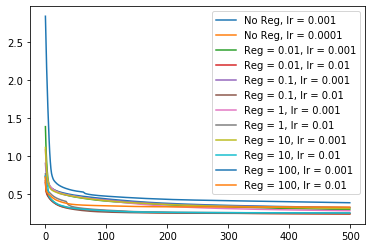

In [35]:
for train_errors in train_error_logs:
    plt.plot(train_errors)

plt.legend([hp['model_name'] for hp in hyperparams])
plt.show()

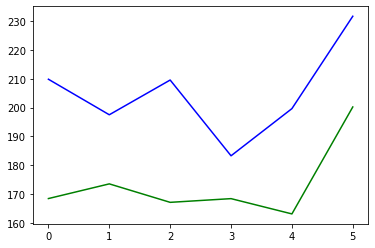

In [36]:
# Let's see how changing the regularization parameter affects
# the validation error.

small_lr = [error for i, error in enumerate(valid_errors) if i % 2 == 0]
large_lr = [error for i, error in enumerate(valid_errors) if i % 2 == 1]

plt.plot(small_lr, c='b')
plt.plot(large_lr, c='g')


In [37]:
best_model_index = np.argmin(valid_errors)
best_model = models[best_model_index]

print(f'The best model is model {best_model_index+1}: {hyperparams[best_model_index]["model_name"]}')

The best model is model 10: Reg = 10, lr = 0.01


In [38]:
# Check accuracy.
correct = np.sum(labels_train == predict(best_model, data_train))
total = len(labels_train)

print(f'{correct} / {total} correct')

1623 / 1800 correct


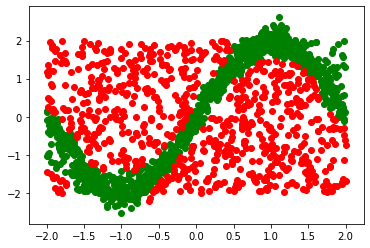

In [39]:
# Visualize the results.

Y_hat = predict(models[0], data_train)

data_positive = data_train[:, Y_hat == 1]
data_negative = data_train[:, Y_hat == 0]

plt.scatter(data_positive[0, :], data_positive[1, :], c='g')
plt.scatter(data_negative[0, :], data_negative[1, :], c='r')
